In [1]:
import os
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
#import dotenv
from tqdm import tqdm
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
import matplotlib.pyplot as plt

## To run Hugging Face OpenSource models
# Needs to manually install Visual C++ Tools from: https://visualstudio.microsoft.com/visual-cpp-build-tools/
from InstructorEmbedding import INSTRUCTOR
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain_community.vectorstores import Chroma

#For some reason, "context" cant be used as input variable, it should be named as "summaries"
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_ollama import OllamaLLM
from langchain.prompts import PromptTemplate
import warnings
from rich import print
import random, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import spacy

# Download necessary NLTK data (run this only once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\Users\USER\OneDrive\maestria\Proyecto Integrador\proyecto_integrador_equipo_27\.venv\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import torch
import torch.nn as nn

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# Print CUDA device name
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True

Device Name: NVIDIA GeForce RTX 3050

In [3]:
# Ensure GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda

### Hyperparameters for this test:

In [4]:
index_test_name = 'TestC'
LLM_model = 'llama3.1'
temperature_parameter=0.08
retriever_matches_k = 5

## Save each iteration to file
output_file_path = '../Prediction_vs_Expected_TestC.csv'

# Load the CSV validation file
#df = pd.read_csv('../../Validation Data.csv', encoding='utf-8', dtype=str)
df = pd.read_csv('../../data validation verified.csv', encoding='utf-8', dtype=str)

In [5]:
# Define directories
# Define the persistent directory containing the VectorDB
script_dir =  os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir,'..' ,'index', index_test_name))

# SE REQUIERE UTILIZAR EL MISMO MODELO DE SENTENCE-TRANSFORMER CON EL QUE SE CREO EL INDEX, sin ello se enfrentaran:
#Espacios Vectoriales Diferentes:
#
#Cada modelo de sentence-transformer genera embeddings en su propio espacio vectorial. Estos espacios son definidos por los pesos y arquitecturas específicas de cada modelo.
#Los embeddings generados por el modelo A no son directamente comparables con los del modelo B porque están en espacios diferentes y no alineados.
#Incompatibilidad de Embeddings:
#
#Las representaciones vectoriales (embeddings) de las mismas frases pueden ser muy distintas entre modelos. Por ejemplo, una oración podría tener un vector [0.1, 0.2, 0.3] en el modelo A y [0.5, -0.1, 0.2] en el modelo B.
#Esto significa que medidas de similitud como la similitud coseno no serán significativas, ya que los vectores no están en el mismo espacio.
#Resultados Incorrectos o Sin Sentido:
#
#Al realizar consultas, las comparaciones entre embeddings del índice (modelo A) y los embeddings de la consulta (modelo B) producirán resultados erróneos.
#Podrías obtener altas similitudes entre oraciones no relacionadas o bajas similitudes entre oraciones muy similares.
#Pérdida de Precisión y Rendimiento:
#
#El rendimiento del sistema de recuperación de información se degradará significativamente.
#Los usuarios recibirán resultados irrelevantes, lo que afecta la usabilidad y confiabilidad del sistema.
#Consistencia en Procesamiento de Lenguaje Natural:
#
#Los modelos pueden tener diferentes enfoques para manejar ciertos aspectos del lenguaje, como negaciones, sarcasmo o lenguaje coloquial.
#Esto añade otra capa de inconsistencia entre los embeddings generados por diferentes modelos.

embed_model = "sentence-transformers/all-mpnet-base-v2"


# Para correr las predicciones en GPU
model_kwargs = {'device': 'cuda:0'}  # specify GPU device
encode_kwargs = {'normalize_embeddings': True}

### Set a Q&A LLM Chain to provide context and system prompts on every query
This will run peristantly, consulting already stored vectors

In [6]:
##### Embedding model (sentence-transformer)
model_name = embed_model
model_kwargs = {'device': 'cuda:0'}  # specify GPU device
encode_kwargs = {'normalize_embeddings': True}
hf_embed_model = HuggingFaceInstructEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

##### LLM model
# loading the Llama3 model from local
llm_model = OllamaLLM(model=LLM_model,
                temperature=temperature_parameter,
                num_thread=8,
                )
# loading the vectorstore
vectorstore = Chroma(persist_directory=persistent_dir, embedding_function=hf_embed_model)
# casting  the vectorstore as the retriever, taking the best 3 similarities
retriever = vectorstore.as_retriever(search_kwargs={"k":retriever_matches_k})

# formating the docs
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

template = """You must respond only with the hs_code from the metadata, avoid responding with any kind of text even if you can be sure if 
the HS code is correct like "I'm unable to provide a response..." or "I cannot provide a response".


context:
{summaries}

Question:
{question}
"""

# Define the LLM chain (using the Llama3.1 model)
llm_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_model,
    chain_type='stuff',
    retriever=retriever,
    return_source_documents=True,  # To get both the answer and source docs
    chain_type_kwargs={
            "prompt": PromptTemplate(
                template=template,
                #For some reason, "context" cant be used as input variable, it should be named as "summaries"
                input_variables=["question", "summaries"],
            ),
        },
)

context = """As a logistics shipping arrival inspector, your primary responsibility is to inspect incoming shipments and accurately classify goods 
using the Harmonized System (HS) code based on the descriptions provided in the shipping manifests. You will thoroughly review the manifest details, 
including product type, material composition, function, and intended use, to determine the correct HS code. 

Your task is to:
Carefully read and analyze the product descriptions from the manifest.
Identify key characteristics of the goods, such as 
type (e.g., electronics, textiles, machinery), 
material (e.g., plastic, metal, organic), 
and usage (e.g., household, industrial, medical).
Use your knowledge of the HS code classification system to assign the most appropriate HS code for each product based on its description.
Ensure compliance with international trade regulations by selecting precise codes to avoid delays or penalties.
Remember to be thorough and accurate in your classification, as this impacts customs processing, tariffs, and legal requirements."""



load INSTRUCTOR_Transformer
max_seq_length  512


### Running isolated test to check example with and without lemmatization/spelling check

In [7]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')


#########  Option 1 - Lemmatization and spell check
## Correct spelling function
#def correct_spelling(text):
#    spell = SpellChecker()
#    words = text.split()  # Tokenize the string into words
#    
#    corrected_words = []
#    for word in words:
#        if word:  # Make sure word is not None or empty
#            corrected_word = spell.correction(word)
#            # Only append non-None words after correction
#            if corrected_word:
#                corrected_words.append(corrected_word)
#    return ' '.join(corrected_words)
#
## Function to perform lemmatization and remove stop words
#def lemmatize_text(text):
#    doc = nlp(text)
#    # Remove tokens that are in the combined stopwords list
#    lemmatized_words = [token.lemma_ for token in doc if token.text not in combined_stopwords]
#    return ' '.join(lemmatized_words)
## Clean text function to avoid garbage
#def clean_text(text):
#    text = text.lower() # Convert text to lowercase
#    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric characters (keep spaces)
#
#    #Lemmatization is a natural language processing (NLP) technique used to reduce a word to its base or root form, known as a lemma, 
#    # while ensuring that the word's meaning is preserved. Unlike stemming, which simply removes suffixes to obtain the base form of a word, 
#    # lemmatization uses linguistic rules and dictionaries (morphological analysis) to ensure that the word is reduced to a valid word 
#    # that makes sense in context.
#
#    # Step 1: Correct spelling
#    corrected_text = correct_spelling(text)
#    #print("Corrected Text:", corrected_text)
#
#    # Step 2: Lemmatize the corrected text
#    lemmatized_text = lemmatize_text(corrected_text)         
#    #print("Lemmatized Text:", lemmatized_text)      
#    return lemmatized_text


#######  Option 2 - Stopwords technique. Simpler but better results
# Clean text function to avoid garbage
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric characters (keep spaces)
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in combined_stopwords]     # Remove stopwords
    # Lemmatization to convert the received sentence to a meaningful sentence
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    meaningful_text = ' '.join(words)
    return meaningful_text 

# Definir stopwords en español y las stopwords adicionales específicas del contexto
stop_words_es = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
additional_stopwords = {
    'hs', 'code', 'hscode', 'hs-code', 'hs  code', 'pallets', 'plts', 'shipper', 'declares', 'hs code',
    'containing', 'contains', 'meter', 'cubic', 'packages', 'load', 'loaded', 'weight', 
    'netweight', 'kg', 'kgs', 'cb', 'cbm', 'goods', 'parts', 'pieces', 'accessories', 'packing', 
    'declared', 'dangerous', 'impression', 'items', 'sheets', 'codes', 
    'sin', 'impresion', 'containers', 'pc', 'abv', 'net', 'gross', 'cif', 'aduana', 'customs', 
    'value', 'tax', 'duty', 'freight', 'port', 'terminal', 'consignee', 'consignor', 'invoice', 
    'manifest', 'quantity', 'description', 'volume', 'packaging', 'shipment', 'delivery', 'origin', 
    'destination', 'transport', 'carrier', 'export', 'import', 'tariff', 'item', 'declaration', 
    'clearance', 'documentation', 'commercial', 'charge', 'fees', 'logistics', 'shipping', 
    'container', 'unit', 'measurement', 'certification', 'palletized', 'metric', 'commodity', 
    'classification', 'entry', 'exportation', 'importation', 'bonded', 'zone', 'trade', 'license', 'bottle', 'bottles', 'cl',
    'ancho', 'largo', 'mm', 'pcs', 'xhc', 'stc', 'uks','x','k', 'pty', 'id', 'cp', 'ncm', 'ne', 'itpa', 'zz', 'xg', 'topmag',
    'rtmx', 'fcl', 'cf','f', 'xdc', 'pkgs'
}

# Combinar stopwords estándar con stopwords del contexto específico
combined_stopwords = stop_words_es.union(stop_words_en).union(additional_stopwords)

#query = "sodium lignosulphonate"
#query = "kilogram organic coffee bean certified fairtrade utz roasted usa global distribution"
query = "prepaidcartons wine"
#query = "xhr said contain package sudu reef shipper seal kn package total versatis mg parches lot r temperature must main taine"


# Execute without cleaning
#For some reason, "context" cant be used as input variable, it should be named as "summaries"
result = llm_chain({"question": query, "summaries": context})
print(f"[bold yellow]The requested item's description RAW to search HTS code is:[/bold yellow]\n{query}")
print(f"[bold green]The response of the LLM is:[/bold green]\n{result['answer']}")

# Execute cleaning
#For some reason, "context" cant be used as input variable, it should be named as "summaries"
result = llm_chain({"question": clean_text(query), "summaries": context})
print(f"[bold yellow]The requested item's description CLEANED to search HTS code is:[/bold yellow]\n{clean_text(query)}")
print(f"[bold green]The response of the LLM is:[/bold green]\n{result['answer']}")


#print("The documents sent to the LLM are:")
#for i in range(len(result["source_documents"])):
#    print(result["source_documents"][i].page_content)
#    print(result["source_documents"][i].metadata)
#     
#results = vectorstore.similarity_search_with_score(query=query, k=retriever_matches_k)
#print("Top n coincidences from the index are:")
#for doc, score in results:
#    print(f"Document content: {doc.page_content}, Code: {doc.metadata},Similarity Score: {score}")
#
#
## Find the document with the highest score
#max_doc, max_score = max(results, key=lambda x: x[1])
#print("Best match from the index is:")
#print(f"Document content: {max_doc.page_content}, Code: {max_doc.metadata}, Similarity Score: {max_score}")



The requested item's description RAW to search HTS code is:
prepaidcartons wine

The response of the LLM is:
2204.10.0000

The requested item's description CLEANED to search HTS code is:
prepaidcartons wine

The response of the LLM is:
2204.10.0000

### Run 50 iterations of 30 random samples each

Running MonteCarlo simulation: 100%|██████████| 50/50 [06:37<00:00,  7.95s/it]


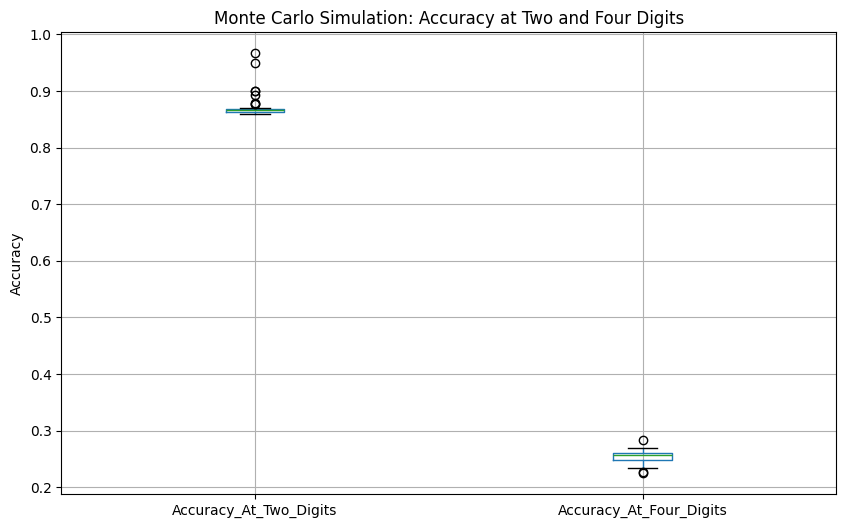

In [9]:
def run_predictions(descriptions_to_predict):
    # Select 30 random queries
    # Shuffle the original DataFrame
    df_shuffled = all_queries.sample(frac=1).reset_index(drop=True)
    selected_queries = df_shuffled.sample(descriptions_to_predict)

    # Now, process each query with llm_chain
    #print("Predicting HS codes of random Validation Data rows...")
    for index, row in selected_queries.iterrows():
        query = clean_text(row['Raw_data_input'])
        expected_output = row['Expected_output']

        # Execute the LLM chain (using a mock prediction for illustration here)
        result = llm_chain({"question": query, "summaries": context})  # This is the actual call
        llm_prediction = result['answer']  # Assuming LLM returns a numeric 6-digit value as the prediction

        # Append the result in the required structure
        results.append({
            "Raw_data_input": row['Raw_data_input'],
            "Raw_data_input_processed": query,
            "LLM_prediction": llm_prediction,  # Here, the prediction from LLM
            "Expected_output": expected_output,
            "Expected_output_two_digits": row['Expected_output_two_digits'],
            "Predicted_output_two_digits": llm_prediction[:2],
            "CorrectMatch_two_digits": 1 if llm_prediction[:2] == row['Expected_output_two_digits'] else 0 ,
            "Expected_output_four_digits": row['Expected_output_four_digits'],
            "Predicted_output_four_digits": llm_prediction[:4],
            "CorrectMatch_four_digits": 1 if llm_prediction[:4] == row['Expected_output_four_digits'] else 0 
        })

    # Convert the results to a DataFrame
    predictions_df = pd.DataFrame(results)

    #Append iteration results to file
    # Check if file exists
    file_exists = os.path.isfile(output_file_path)

    # Append to the file, write header only if file doesn't already exist
    predictions_df.to_csv(output_file_path, mode='a', header=not file_exists, index=False)

    return predictions_df

# Function to calculate accuracy (both for 2 and 4 digits)
def calculate_accuracy(iteration_df):
    correct_two_digits = 0
    correct_four_digits = 0
    total = len(iteration_df)

    for index, row in iteration_df.iterrows():
        best_hs_code = str(row['LLM_prediction'])[:4]
        hs_actual = str(row['Expected_output'])[:4]

        # Check 2-digit accuracy
        if best_hs_code[:2] == hs_actual[:2]:
            correct_two_digits += 1

        # Check 4-digit accuracy
        if best_hs_code == hs_actual:
            correct_four_digits += 1

    accuracy_at_two_digits = correct_two_digits / total if total > 0 else 0
    accuracy_at_four_digits = correct_four_digits / total if total > 0 else 0

    return accuracy_at_two_digits, accuracy_at_four_digits

n_iterations = 50
n_predictions = 30
accuracy_results_list = []
# Create an empty list to store the results
results = []

# Extract the queries from the 'Raw_data_input' column
all_queries = df[['Raw_data_input', 'Expected_output','Expected_output_two_digits', 'Expected_output_four_digits']].dropna()  # Ensure no missing values

for iteration in tqdm(range(n_iterations), desc="Running MonteCarlo simulation"):
    #print("Running iteration #:" , iteration+1)
    iteration_df = run_predictions(n_predictions)
    # Calculate accuracy
    acc_two_digits, acc_four_digits = calculate_accuracy(iteration_df)

    # Store the results
    accuracy_results_list.append([iteration + 1, acc_two_digits, acc_four_digits])
    #print("Accuracy of this iteration: ", acc_two_digits, acc_four_digits)

# Convert results to DataFrame for further analysis
accuracy_results_df = pd.DataFrame(accuracy_results_list, columns=['Iteration', 'Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits'])
accuracy_results_df

plt.figure(figsize=(10, 6))
accuracy_results_df[['Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits']].boxplot()
plt.title('Monte Carlo Simulation: Accuracy at Two and Four Digits')
plt.ylabel('Accuracy')
plt.show()
